In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, mean_squared_error)
from sklearn.preprocessing import label_binarize
from PIL import Image

# Set device: use MPS on Apple Silicon if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)



Using device: mps


In [2]:
# -----------------------------------
# Model Definition: TunedResNet18
# -----------------------------------

class TunedResNet18(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super(TunedResNet18, self).__init__()
        # Load pre-trained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        # Replace final fc layer with a custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)



In [3]:
# -----------------------------------
# Dataset Definition: FaceCroppedDataset
# -----------------------------------

class FaceCroppedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = image[y:y+h, x:x+w]
        else:
            face = image  # fallback if no face is detected
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)
        if self.transform:
            face = self.transform(face)
        return face, label



In [4]:
# -----------------------------------
# Data Transforms and Loaders
# -----------------------------------

# Define transformation (for both test and cross-validation, we use the same for simplicity)
# Training transform with additional augmentation (flipping, rotation)
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),           # Flip images horizontally
    transforms.RandomRotation(degrees=15),         # Rotate images up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Testing/validation transform (no random augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [5]:
# Update this path to your facial emotion data directory
data_dir = "FER-2013" 

# Load test dataset
test_dataset = FaceCroppedDataset(os.path.join(data_dir, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# For cross-validation, use a subset of training data to save time
full_train_dataset = FaceCroppedDataset(os.path.join(data_dir, "train"), transform=train_transform)
subset_ratio = 0.3  # use 30% of the training data
num_train_samples = int(len(full_train_dataset) * subset_ratio)
indices = np.random.choice(len(full_train_dataset), num_train_samples, replace=False)
cv_dataset = Subset(full_train_dataset, indices)

# Extract labels for cross-validation splitting (from the underlying ImageFolder)
cv_labels = [full_train_dataset.dataset.samples[i][1] for i in indices]

# -----------------------------------
# Load Saved Model
# -----------------------------------

# Define best hyperparameters from the saved model
best_hidden_size = 256
best_dropout_rate = 0.3
num_classes = 6  # "angry", "fear", "happy", "natural", "sad", "surprise"

# Specify the model file path
model_path = os.path.join("Models/resnet18_fer-2013_best_hs256_drop0.3_lr0.0001_adam.pt")

# Instantiate the model and load weights
model_fer = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
model_fer.load_state_dict(torch.load(model_path))
model_fer.to(device)
print("Loaded model from:", model_path)

# Get class names from the training dataset (assuming the folder names correspond to your classes)
classes = full_train_dataset.dataset.classes
print("Classes:", classes)



Loaded model from: Models/resnet18_fer-2013_best_hs256_drop0.3_lr0.0001_adam.pt
Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
# -----------------------------------
# Training Helper Functions
# -----------------------------------

def train_one_epoch(model, optimizer, criterion, loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_model(model, criterion, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_targets




Starting Fold 1
Fold 1 Epoch 1/5: Train Loss: 1.3570, Train Acc: 0.4777, Val Loss: 1.2842, Val Acc: 0.5055
Fold 1 Epoch 2/5: Train Loss: 1.2471, Train Acc: 0.5253, Val Loss: 1.3630, Val Acc: 0.4733
Fold 1 Epoch 3/5: Train Loss: 1.1823, Train Acc: 0.5458, Val Loss: 1.2675, Val Acc: 0.5189
Fold 1 Epoch 4/5: Train Loss: 1.1478, Train Acc: 0.5665, Val Loss: 1.3880, Val Acc: 0.4712
Fold 1 Epoch 5/5: Train Loss: 1.1294, Train Acc: 0.5630, Val Loss: 1.1862, Val Acc: 0.5416

Starting Fold 2
Fold 2 Epoch 1/5: Train Loss: 1.3214, Train Acc: 0.4859, Val Loss: 1.2326, Val Acc: 0.5203
Fold 2 Epoch 2/5: Train Loss: 1.2241, Train Acc: 0.5241, Val Loss: 1.1938, Val Acc: 0.5380
Fold 2 Epoch 3/5: Train Loss: 1.1791, Train Acc: 0.5470, Val Loss: 1.1966, Val Acc: 0.5511
Fold 2 Epoch 4/5: Train Loss: 1.1497, Train Acc: 0.5693, Val Loss: 1.2683, Val Acc: 0.5295
Fold 2 Epoch 5/5: Train Loss: 1.1125, Train Acc: 0.5764, Val Loss: 1.2402, Val Acc: 0.5391

Starting Fold 3
Fold 3 Epoch 1/5: Train Loss: 1.3308, T

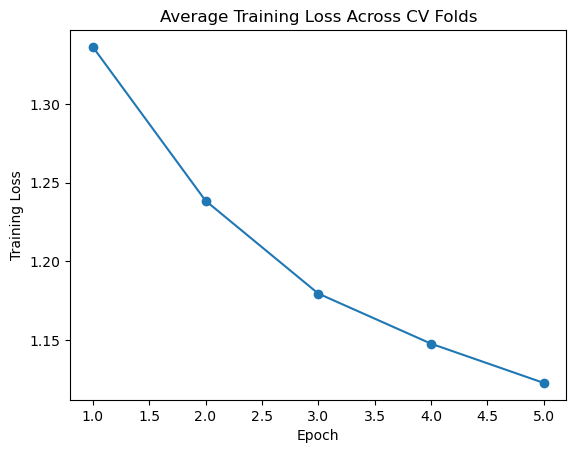

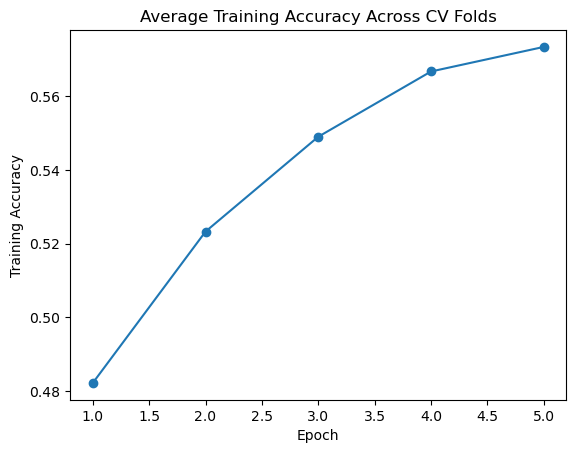

In [7]:
# -----------------------------------
# Cross-Validation Training
# -----------------------------------

# Use StratifiedKFold for CV (e.g., 3-fold CV)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_train_accuracies = []
cv_losses = []
cv_accuracies = []
num_epochs_cv = 5  # Adjust epochs for CV

fold = 0
for train_idx, val_idx in kfold.split(np.zeros(len(cv_dataset)), cv_labels):
    fold += 1
    print(f"\nStarting Fold {fold}")
    train_subset = Subset(cv_dataset, train_idx)
    val_subset = Subset(cv_dataset, val_idx)
    train_loader_cv = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader_cv = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # For each fold, initialize a fresh copy of the model and load saved weights
    fold_model = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
    fold_model.load_state_dict(torch.load(model_path))
    fold_model.to(device)
    
    optimizer = optim.Adam(fold_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    fold_train_losses = []
    fold_train_accuracies = []
    
    for epoch in range(num_epochs_cv):
        train_loss, train_acc = train_one_epoch(fold_model, optimizer, criterion, train_loader_cv, device)
        val_loss, val_acc, _, _ = validate_model(fold_model, criterion, val_loader_cv, device)
        fold_train_losses.append(train_loss)
        fold_train_accuracies.append(train_acc)
        print(f"Fold {fold} Epoch {epoch+1}/{num_epochs_cv}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    all_fold_train_losses.append(fold_train_losses)
    all_fold_train_accuracies.append(fold_train_accuracies)
    cv_losses.append(fold_train_losses[-1])
    cv_accuracies.append(fold_train_accuracies[-1])

print("\nCross Validation Results:")
print("Average Final Train Loss:", np.mean([losses[-1] for losses in all_fold_train_losses]))
print("Average Final Train Accuracy:", np.mean([accs[-1] for accs in all_fold_train_accuracies]))

# Plot average training loss and accuracy across folds
epochs_range = range(1, num_epochs_cv+1)
avg_train_losses = np.mean(all_fold_train_losses, axis=0)
avg_train_accuracies = np.mean(all_fold_train_accuracies, axis=0)

plt.figure()
plt.plot(epochs_range, avg_train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Average Training Loss Across CV Folds')
plt.show()

plt.figure()
plt.plot(epochs_range, avg_train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Average Training Accuracy Across CV Folds')
plt.show()



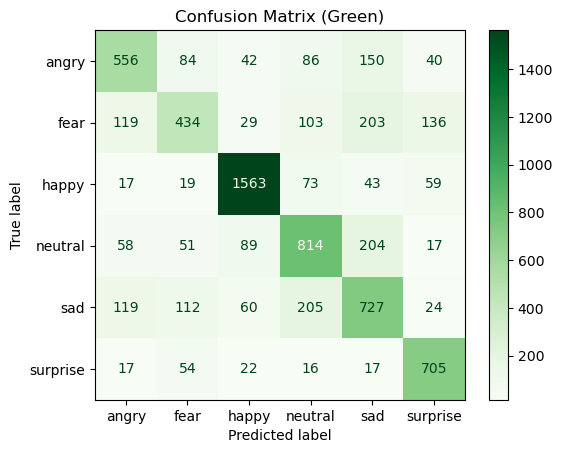


Evaluation Metrics:
Precision (Macro): 0.6594
Recall (Macro): 0.6628
F1 Score (Macro): 0.6579
Precision (Weighted): 0.6753
Recall (Weighted): 0.6791
F1 Score (Weighted): 0.6745
ROC-AUC: 0.9121
PR-AUC: 0.7169
MSE: 2.2482
RMSE: 1.4994

Classification Report:
              precision    recall  f1-score   support

       angry       0.63      0.58      0.60       958
        fear       0.58      0.42      0.49      1024
       happy       0.87      0.88      0.87      1774
     neutral       0.63      0.66      0.64      1233
         sad       0.54      0.58      0.56      1247
    surprise       0.72      0.85      0.78       831

    accuracy                           0.68      7067
   macro avg       0.66      0.66      0.66      7067
weighted avg       0.68      0.68      0.67      7067



In [8]:
# -----------------------------------
# Final Evaluation on Test Data
# -----------------------------------

model_fer.eval()
all_preds = []
all_targets = []
all_probs = []  # For probability outputs

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_fer(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Plot confusion matrix with green colormap
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix (Green)")
plt.show()

# Compute evaluation metrics
precision_macro = precision_score(all_targets, all_preds, average='macro')
recall_macro = recall_score(all_targets, all_preds, average='macro')
f1_macro = f1_score(all_targets, all_preds, average='macro')
precision_weighted = precision_score(all_targets, all_preds, average='weighted')
recall_weighted = recall_score(all_targets, all_preds, average='weighted')
f1_weighted = f1_score(all_targets, all_preds, average='weighted')

# For ROC-AUC and PR-AUC, binarize the targets
all_targets_bin = label_binarize(all_targets, classes=range(num_classes))
roc_auc = roc_auc_score(all_targets_bin, all_probs, average='macro', multi_class='ovr')
pr_auc = average_precision_score(all_targets_bin, all_probs, average='macro')

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)

print("\nEvaluation Metrics:")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

In [9]:
# -----------------------------------
# Load Saved Model RAF
# -----------------------------------

# Define best hyperparameters from the saved model
best_hidden_size = 256
best_dropout_rate = 0.3
num_classes = 6  # "angry", "fear", "happy", "natural", "sad", "surprise"

# Specify the model file path
model_path = os.path.join("Models/resnet18_best_RAF-DB_256_drop0.3_lr0.0001_adam.pt")

# Instantiate the model and load weights
model_raf = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
model_raf.load_state_dict(torch.load(model_path))
model_raf.to(device)
print("Loaded model from:", model_path)

# Get class names from the training dataset (assuming the folder names correspond to your classes)
classes = full_train_dataset.dataset.classes
print("Classes:", classes)

Loaded model from: Models/resnet18_best_RAF-DB_256_drop0.3_lr0.0001_adam.pt
Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']



Starting Fold 1
Fold 1 Epoch 1/5: Train Loss: 1.4262, Train Acc: 0.4377, Val Loss: 1.3995, Val Acc: 0.4503
Fold 1 Epoch 2/5: Train Loss: 1.2810, Train Acc: 0.5005, Val Loss: 1.3190, Val Acc: 0.4924
Fold 1 Epoch 3/5: Train Loss: 1.2506, Train Acc: 0.5242, Val Loss: 1.1980, Val Acc: 0.5373
Fold 1 Epoch 4/5: Train Loss: 1.1764, Train Acc: 0.5432, Val Loss: 1.3116, Val Acc: 0.4970
Fold 1 Epoch 5/5: Train Loss: 1.1639, Train Acc: 0.5513, Val Loss: 1.2108, Val Acc: 0.5476

Starting Fold 2
Fold 2 Epoch 1/5: Train Loss: 1.4375, Train Acc: 0.4471, Val Loss: 1.3754, Val Acc: 0.4917
Fold 2 Epoch 2/5: Train Loss: 1.2959, Train Acc: 0.5023, Val Loss: 1.2783, Val Acc: 0.5094
Fold 2 Epoch 3/5: Train Loss: 1.2270, Train Acc: 0.5253, Val Loss: 1.2518, Val Acc: 0.5164
Fold 2 Epoch 4/5: Train Loss: 1.1941, Train Acc: 0.5460, Val Loss: 1.2243, Val Acc: 0.5235
Fold 2 Epoch 5/5: Train Loss: 1.1515, Train Acc: 0.5520, Val Loss: 1.2010, Val Acc: 0.5419

Starting Fold 3
Fold 3 Epoch 1/5: Train Loss: 1.4263, T

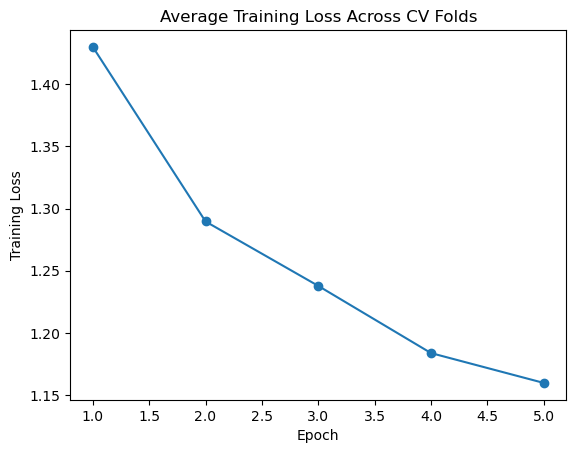

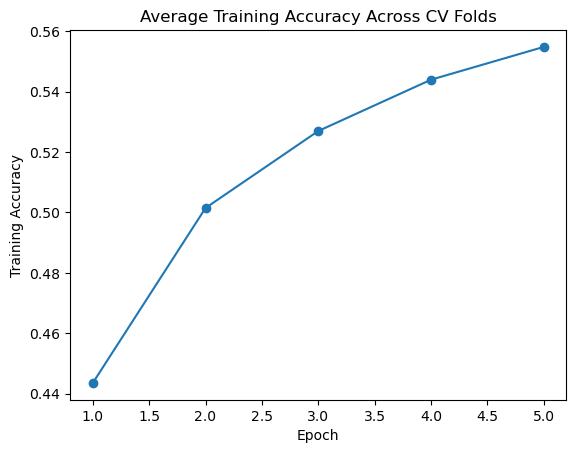

In [10]:
# -----------------------------------
# Cross-Validation Training
# -----------------------------------

# Use StratifiedKFold for CV (e.g., 3-fold CV)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_train_accuracies = []
cv_losses = []
cv_accuracies = []
num_epochs_cv = 5  # Adjust epochs for CV

fold = 0
for train_idx, val_idx in kfold.split(np.zeros(len(cv_dataset)), cv_labels):
    fold += 1
    print(f"\nStarting Fold {fold}")
    train_subset = Subset(cv_dataset, train_idx)
    val_subset = Subset(cv_dataset, val_idx)
    train_loader_cv = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader_cv = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # For each fold, initialize a fresh copy of the model and load saved weights
    fold_model = TunedResNet18(num_classes=num_classes, hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
    fold_model.load_state_dict(torch.load(model_path))
    fold_model.to(device)
    
    optimizer = optim.Adam(fold_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    fold_train_losses = []
    fold_train_accuracies = []
    
    for epoch in range(num_epochs_cv):
        train_loss, train_acc = train_one_epoch(fold_model, optimizer, criterion, train_loader_cv, device)
        val_loss, val_acc, _, _ = validate_model(fold_model, criterion, val_loader_cv, device)
        fold_train_losses.append(train_loss)
        fold_train_accuracies.append(train_acc)
        print(f"Fold {fold} Epoch {epoch+1}/{num_epochs_cv}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    all_fold_train_losses.append(fold_train_losses)
    all_fold_train_accuracies.append(fold_train_accuracies)
    cv_losses.append(fold_train_losses[-1])
    cv_accuracies.append(fold_train_accuracies[-1])

print("\nCross Validation Results:")
print("Average Final Train Loss:", np.mean([losses[-1] for losses in all_fold_train_losses]))
print("Average Final Train Accuracy:", np.mean([accs[-1] for accs in all_fold_train_accuracies]))

# Plot average training loss and accuracy across folds
epochs_range = range(1, num_epochs_cv+1)
avg_train_losses = np.mean(all_fold_train_losses, axis=0)
avg_train_accuracies = np.mean(all_fold_train_accuracies, axis=0)

plt.figure()
plt.plot(epochs_range, avg_train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Average Training Loss Across CV Folds')
plt.show()

plt.figure()
plt.plot(epochs_range, avg_train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Average Training Accuracy Across CV Folds')
plt.show()



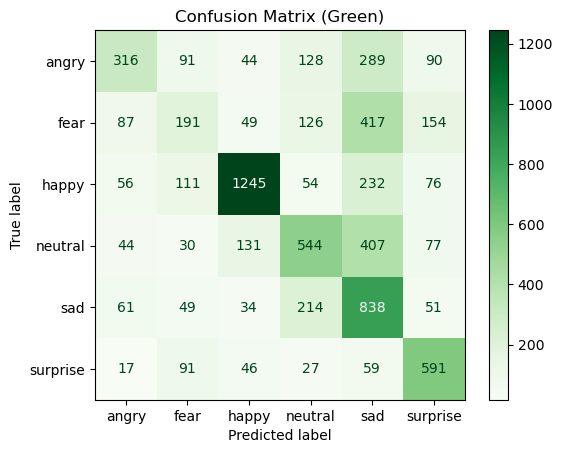


Evaluation Metrics:
Precision (Macro): 0.5212
Recall (Macro): 0.5071
F1 Score (Macro): 0.4968
Precision (Weighted): 0.5443
Recall (Weighted): 0.5271
F1 Score (Weighted): 0.5193
ROC-AUC: 0.8062
PR-AUC: 0.5196
MSE: 3.2253
RMSE: 1.7959

Classification Report:
              precision    recall  f1-score   support

       angry       0.54      0.33      0.41       958
        fear       0.34      0.19      0.24      1024
       happy       0.80      0.70      0.75      1774
     neutral       0.50      0.44      0.47      1233
         sad       0.37      0.67      0.48      1247
    surprise       0.57      0.71      0.63       831

    accuracy                           0.53      7067
   macro avg       0.52      0.51      0.50      7067
weighted avg       0.54      0.53      0.52      7067



In [11]:
# -----------------------------------
# Final Evaluation on Test Data
# -----------------------------------

model_raf.eval()
all_preds = []
all_targets = []
all_probs = []  # For probability outputs

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_raf(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Plot confusion matrix with green colormap
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix (Green)")
plt.show()

# Compute evaluation metrics
precision_macro = precision_score(all_targets, all_preds, average='macro')
recall_macro = recall_score(all_targets, all_preds, average='macro')
f1_macro = f1_score(all_targets, all_preds, average='macro')
precision_weighted = precision_score(all_targets, all_preds, average='weighted')
recall_weighted = recall_score(all_targets, all_preds, average='weighted')
f1_weighted = f1_score(all_targets, all_preds, average='weighted')

# For ROC-AUC and PR-AUC, binarize the targets
all_targets_bin = label_binarize(all_targets, classes=range(num_classes))
roc_auc = roc_auc_score(all_targets_bin, all_probs, average='macro', multi_class='ovr')
pr_auc = average_precision_score(all_targets_bin, all_probs, average='macro')

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)

print("\nEvaluation Metrics:")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))